
Our dataset consists of clinical data from patients who entered the hospital complaining of chest pain ("angina") during exercise.  The information collected includes:

* `age` : Age of the patient

* `sex` : Sex of the patient

* `cp` : Chest Pain type

    + Value 0: asymptomatic
    + Value 1: typical angina
    + Value 2: atypical angina
    + Value 3: non-anginal pain
   
    
* `trtbps` : resting blood pressure (in mm Hg)

* `chol` : cholesterol in mg/dl fetched via BMI sensor

* `restecg` : resting electrocardiographic results

    + Value 0: normal
    + Value 1: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV)
    + Value 2: showing probable or definite left ventricular hypertrophy by Estes' criteria

* `thalach` : maximum heart rate achieved during exercise

* `output` : the doctor's diagnosis of whether the patient is at risk for a heart attack
    + 0 = not at risk of heart attack
    + 1 = at risk of heart attack

In [56]:
## library imports here
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.compose import make_column_selector, ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import *
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree
from plotnine import *

In [57]:
ha = pd.read_csv("https://www.dropbox.com/s/aohbr6yb9ifmc8w/heart_attack.csv?dl=1")
data = pd.DataFrame(ha)
data

,age,sex,cp,trtbps,chol,restecg,thalach,output
0,63,1,3,145,233,0,150,1
1,37,1,2,130,250,1,187,1
2,56,1,1,120,236,1,178,1
3,57,0,0,120,354,1,163,1
4,57,1,0,140,192,1,148,1
...,...,...,...,...,...,...,...,...
268,59,1,0,164,176,0,90,0
269,57,0,0,140,241,1,123,0
270,45,1,3,110,264,1,132,0
271,68,1,0,144,193,1,141,0


## Q1: Natural Multiclass Models

Fit a multiclass KNN, Decision Tree, and LDA for the heart disease data; this time predicting the type of chest pain (categories 0 - 3) that a patient experiences.  For the decision tree, plot the fitted tree, and interpret the first couple splits.


In [58]:
X = data.drop(["cp"], axis = 1)
y = data["cp"]

data['restecg'] = data['restecg'].astype('object')
data['sex'] = data['sex'].astype('object')
data['output'] = data['output'].astype('object')

# make_column_selector selects columns to dummify, and scale numerical 
ct = ColumnTransformer(
  [
    ("dummify", OneHotEncoder(sparse_output = False, handle_unknown='ignore'),
    make_column_selector(dtype_include=object)),
    ("standardize", StandardScaler(), make_column_selector(dtype_include=np.number))
  ],
  remainder = "passthrough" # keeps all variables
)


# KNN
knn_pipeline_1 = Pipeline(
  [("preprocessing", ct),
  ("knn", KNeighborsClassifier())]
)

# DT
dt_pipeline_1 = Pipeline(
  [("preprocessing", ct),
  ("decision_tree", DecisionTreeClassifier())]
)

# LDA
lda_pipeline_1 = Pipeline(
  [("preprocessing", ct),
  ("linear_discriminant_analysis", LinearDiscriminantAnalysis())]
)

lda_fit = lda_pipeline_1.fit(X,y)

# KNN Model 1 
parameters_knn = {'knn__n_neighbors': (5, 10, 15, 20, 25, 30, 35, 40, 45, 50)}

gscv = GridSearchCV(knn_pipeline_1, parameters_knn, cv = 5, scoring='accuracy')

gscv_fitted_knn1 = gscv.fit(X, y)

gscv_fitted_knn1.cv_results_

means_knn1 = gscv_fitted_knn1.cv_results_['mean_test_score']
params = gscv_fitted_knn1.cv_results_['params']

knn_model_1 = {'x': params, 'accuracy': means_knn1}
knn_model_1 = pd.DataFrame(knn_model_1)
pd.set_option('display.max_colwidth', None)
knn_model_1 = knn_model_1.sort_values(by = "accuracy", ascending = False)
print('KNN Accuracy', knn_model_1.head(1))



# DT Model 1 
parameters_dt = {'decision_tree__min_samples_leaf': (5, 10, 15, 20, 25, 30, 35, 40)}

gscv = GridSearchCV(dt_pipeline_1, parameters_dt, cv = 5, scoring='accuracy')

gscv_fitted_dt = gscv.fit(X, y)

gscv_fitted_dt.cv_results_

means_dt1 = gscv_fitted_dt.cv_results_['mean_test_score']
params = gscv_fitted_dt.cv_results_['params']

dt_model_1 = {'x': params, 'accuracy': means_dt1}
dt_model_1 = pd.DataFrame(dt_model_1)
pd.set_option('display.max_colwidth', None)
dt_model_1 = dt_model_1.sort_values(by = "accuracy", ascending = False)
print('DT Accuracy',dt_model_1.head(1))


# LDA 
scores = (cross_val_score(lda_fit, X, y, cv=5, scoring = 'accuracy'))
mean_score = np.mean(scores)
print('LDA Accuracy', mean_score)

KNN Accuracy                           x  accuracy
6  {'knn__n_neighbors': 35}  0.538653
DT Accuracy                                          x  accuracy
6  {'decision_tree__min_samples_leaf': 35}  0.552997
LDA Accuracy 0.5424242424242424


### Plotting Decision Tree 

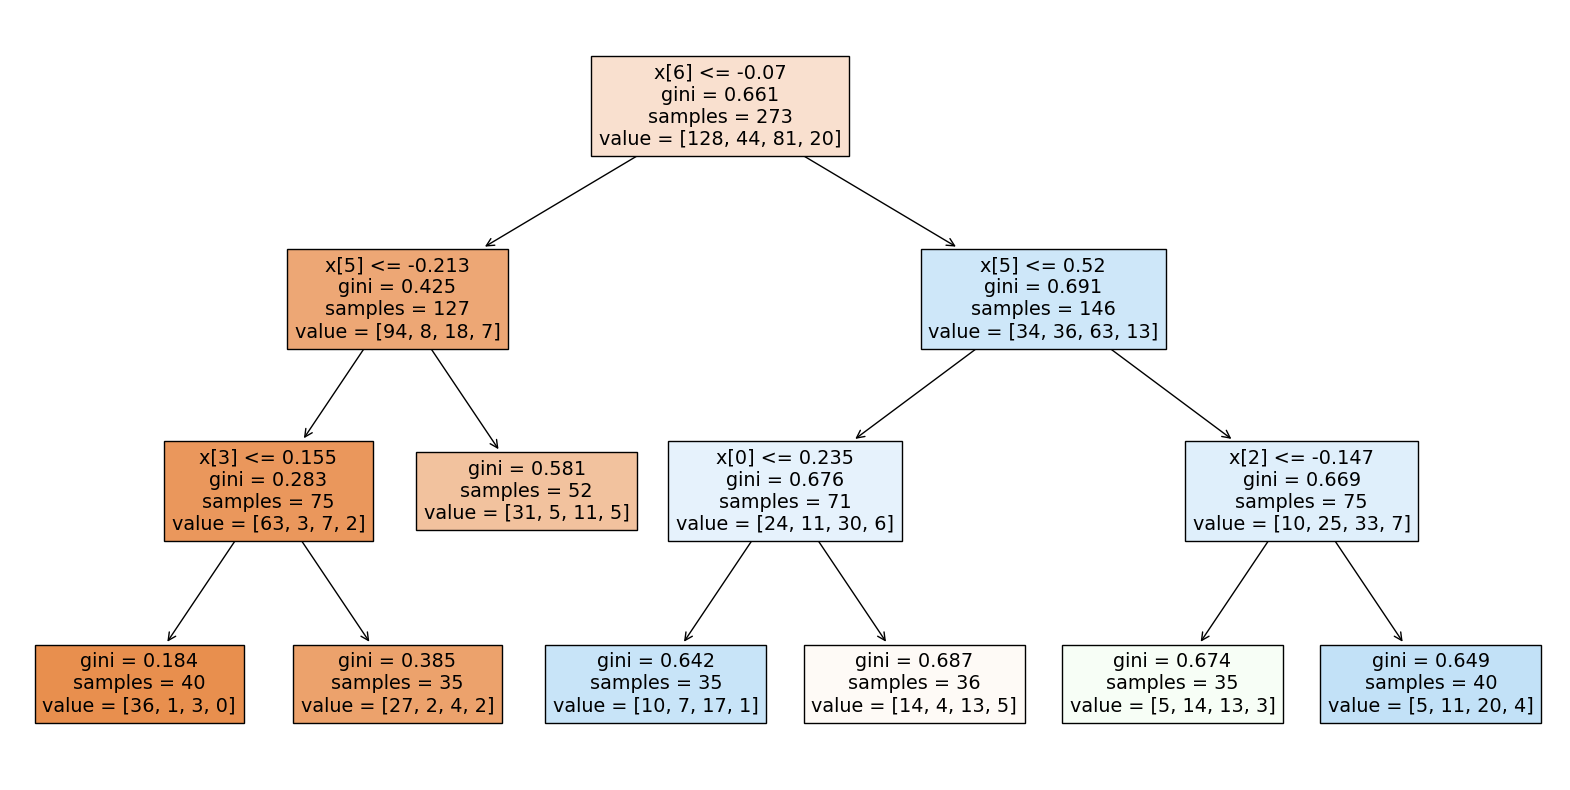

In [59]:
# Plot the decision tree
best_dt_model = gscv_fitted_dt.best_estimator_.named_steps['decision_tree']

plt.figure(figsize=(20,10))  # Set the size of the figure
plot_tree(best_dt_model, filled=True)
plt.show()

In [60]:
# Determine what X[5] and [6] indicate
ct.fit(data)

feature_names = ct.get_feature_names_out()

feature_name_at_5 = feature_names[5]
feature_name_at_6 = feature_names[6]

print(feature_name_at_5,feature_name_at_6)

dummify__output_0 dummify__output_1


**According to the Decision Tree the most important variable in terms of predicting the type of chest pain a patient has is Output (the prediction of heart disease).  If this value is less than -0.07 or 0, then the decision tree splits left but if 1, then it goes right, indicating a higher risk path of disease.**

## Q2:  OvR

Create a new column in the `ha` dataset called `cp_is_3`, which is equal to `1` if the `cp` variable is equal to `3` and `0` otherwise.

Then, fit a Logistic Regression to predict this new target, and report the **F1 Score**.

Repeat for the other three `cp` categories.  Which category was the OvR approach best at distinguishing?

In [61]:
data['cp_is_3'] = (data['cp'] == 3).astype(int)
data['cp_is_2'] = (data['cp'] == 2).astype(int)
data['cp_is_1'] = (data['cp'] == 1).astype(int)
data['cp_is_0'] = (data['cp'] == 0).astype(int)

data['restecg'] = data['restecg'].astype('object')
data['sex'] = data['sex'].astype('object')
data['output'] = data['output'].astype('object')

X_1 = data.drop(["cp_is_0","cp_is_1","cp_is_2","cp_is_3","cp"], axis = 1)
y_1 = data["cp_is_1"]

X_2 = data.drop(["cp_is_0","cp_is_1","cp_is_2","cp_is_3","cp"], axis = 1)
y_2 = data["cp_is_2"]

X_3 = data.drop(["cp_is_0","cp_is_1","cp_is_2","cp_is_3","cp"], axis = 1)
y_3 = data["cp_is_3"]

X_0 = data.drop(["cp_is_0","cp_is_1","cp_is_2","cp_is_3","cp"], axis = 1)
y_0 = data["cp_is_0"]


# make_column_selector selects columns to dummify, and scale numerical 
ct = ColumnTransformer(
  [
    ("dummify", OneHotEncoder(sparse_output = False, handle_unknown='ignore'),
    make_column_selector(dtype_include=object)),
    ("standardize", StandardScaler(), make_column_selector(dtype_include=np.number))
  ],
  remainder = "passthrough" # keeps all variables
)

log_pipeline_1 = Pipeline(
  [("preprocessing", ct),
  ("logistic", LogisticRegression())]
)

log_fit_0 = log_pipeline_1.fit(X_0,y_0)
log_fit_1 = log_pipeline_1.fit(X_1,y_1)
log_fit_2 = log_pipeline_1.fit(X_2,y_2)
log_fit_3 = log_pipeline_1.fit(X_3,y_3)

# Log 
scores = (cross_val_score(log_fit_0, X_0, y_0, cv=5, scoring = 'f1_micro'))
mean_score = np.mean(scores)

scores_1 = (cross_val_score(log_fit_1, X_1, y_1, cv=5, scoring = 'f1_micro'))
mean_score1 = np.mean(scores_1)

scores_2 = (cross_val_score(log_fit_2, X_2, y_2, cv=5, scoring = 'f1_micro'))
mean_score2 = np.mean(scores_2)

scores_3 = (cross_val_score(log_fit_3, X_3, y_3, cv=5, scoring = 'f1_micro'))
mean_score3 = np.mean(scores_3)

print("Log F1 Micro: Cp_0 -", mean_score)
print("Log F1 Micro: Cp_1 -", mean_score1)
print("Log F1 Micro: Cp_2 -", mean_score2)
print("Log F1 Micro: Cp_3 -", mean_score3)


Log F1 Micro: Cp_0 - 0.7284848484848484
Log F1 Micro: Cp_1 - 0.8315824915824915
Log F1 Micro: Cp_2 - 0.6014814814814815
Log F1 Micro: Cp_3 - 0.9230303030303031


In [62]:
# Log 
scores = (cross_val_score(log_fit_0, X_0, y_0, cv=5, scoring = 'f1_macro'))
mean_score = np.mean(scores)

scores_1 = (cross_val_score(log_fit_1, X_1, y_1, cv=5, scoring = 'f1_macro'))
mean_score1 = np.mean(scores_1)

scores_2 = (cross_val_score(log_fit_2, X_2, y_2, cv=5, scoring = 'f1_macro'))
mean_score2 = np.mean(scores_2)

scores_3 = (cross_val_score(log_fit_3, X_3, y_3, cv=5, scoring = 'f1_macro'))
mean_score3 = np.mean(scores_3)

print("Log F1 Macro: Cp_0 -", mean_score)
print("Log F1 Macro: Cp_1 -", mean_score1)
print("Log F1 Macro: Cp_2 -", mean_score2)
print("Log F1 Macro: Cp_3 -", mean_score3)

Log F1 Macro: Cp_0 - 0.6616486936357965
Log F1 Macro: Cp_1 - 0.45397619761976193
Log F1 Macro: Cp_2 - 0.42268349670924554
Log F1 Macro: Cp_3 - 0.4799787225048261


## Q3: OvO

Reduce your dataset to only the `0` and `1` types of chest pain.

Then, fit a Logistic Regression to predict between the two groups, and report the **ROC-AUC**.  

Repeat comparing category `0` to `2` and `3`.  Which pair was the OvO approach best at distinguishing?

# 0 to 1

In [65]:
data_01 = data[data['cp'].isin([0, 1])]
y_01 = (data_01['cp'] == 1).astype(int)

# Drop the 'cp' and all one-hot encoded cp columns 
X_01 = data_01.drop(['cp', 'cp_is_0', 'cp_is_1', 'cp_is_2', 'cp_is_3'], axis=1)

log_fit_01 = log_pipeline_1.fit(X_01, y_01)

# Predict the probabilities for the positive class (cp_1)
probs_01 = log_fit_01.predict_proba(X_01)[:, 1]

# Calculate the ROC-AUC score
roc_auc_01 = roc_auc_score(y_01, probs_01)
print("ROC-AUC for cp_0 vs cp_1:", roc_auc_01)

ROC-AUC for cp_0 vs cp_2: 0.8442826704545455


# 0 to 2

In [64]:
data_02 = data[data['cp'].isin([0, 2])]
y_02 = (data_02['cp'] == 2).astype(int)

# Drop the 'cp' and all one-hot encoded cp columns 
X_02 = data_02.drop(['cp', 'cp_is_0', 'cp_is_1', 'cp_is_2', 'cp_is_3'], axis=1)

log_fit_02 = log_pipeline_1.fit(X_02, y_02)

# Predict the probabilities for the positive class (cp_2)
probs_02 = log_fit_02.predict_proba(X_02)[:, 1]

# Calculate the ROC-AUC score
roc_auc_02 = roc_auc_score(y_02, probs_02)
print("ROC-AUC for cp_0 vs cp_2:", roc_auc_02)

ROC-AUC for cp_0 vs cp_2: 0.8080632716049382


# 0 to 3

In [66]:
data_03 = data[data['cp'].isin([0, 3])]
y_03 = (data_03['cp'] == 3).astype(int)

# Drop the 'cp' and all one-hot encoded cp columns 
X_03 = data_03.drop(['cp', 'cp_is_0', 'cp_is_1', 'cp_is_2', 'cp_is_3'], axis=1)

log_fit_03 = log_pipeline_1.fit(X_03, y_03)

# Predict the probabilities for the positive class (cp_2)
probs_03 = log_fit_03.predict_proba(X_03)[:, 1]

# Calculate the ROC-AUC score
roc_auc_03 = roc_auc_score(y_03, probs_03)
print("ROC-AUC for cp_0 vs cp_3:", roc_auc_03)

ROC-AUC for cp_0 vs cp_3: 0.828125


**CP_0 vs CP_1 was the best OvO pair at distiguishing our classification with the highest ROC_Auc of 0.844.**  